In [2]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
events_raw = np.loadtxt(path + "data/sim/events.txt")

In [4]:
events_ref = flt.filter_refract(events_raw, 0.05)

In [5]:
start_time = 0.495000000
duration = 0.1
events_t = flt.filter_time(events_ref, start_time, start_time+duration)

In [6]:
# patch_center = (155, 47)
# patch_size = 20
patch_center = (90, 90)
patch_size = 180
shape = (patch_size, patch_size)
events = flt.filter_patch(events_t, patch_center, patch_size)

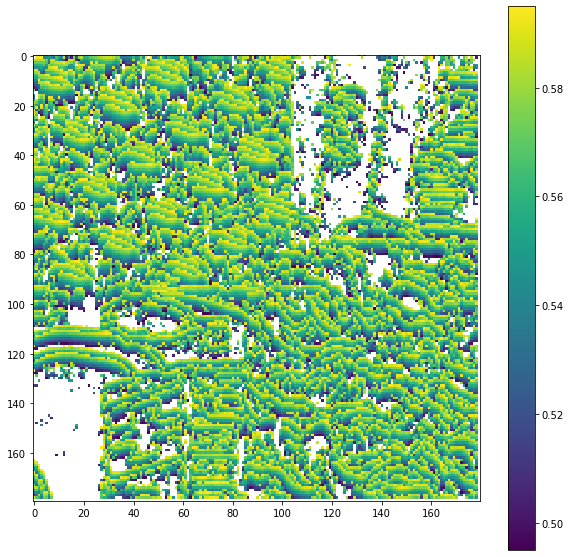

In [7]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
plt.colorbar(mappable=m)

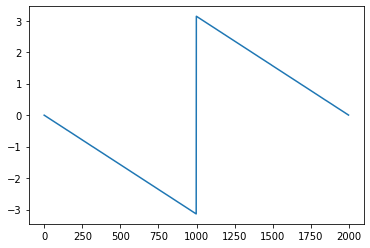

In [8]:
gt = np.loadtxt(path + "data/sim/groundtruth.txt")
speed = np.array([gt[1:,1] - gt[:-1, 1], gt[1:,2] - gt[:-1, 2]]) / (gt[1:,0] - gt[:-1, 0])
directions = np.arctan2(speed[1], speed[0])
#directions = np.mod(directions, 2*np.pi)
plt.plot(directions)

In [16]:
last_time = np.full(shape, -1.0)
dist = 2
td_predictions = {}
predictions = {}
px_range_pred = 7
event_sign = np.full(shape, -1)

angles = []

U = np.zeros(shape)
V = np.zeros(shape)
ofs = np.zeros(shape)

final_td = np.zeros(shape)

for e in tqdm(events):
    x = int(e[1])
    y = int(e[2])
    
#     if e[3] == 0:
#         continue
    
    last_sign = event_sign[y, x]
    last_time[y, x] = e[0]
    event_sign[y, x] = e[3]
    
    u_td = (e[0] - last_time[y-dist, x] 
            if y-dist >= 0 and last_time[y-dist, x] != -1.0 and event_sign[y-dist, x] == e[3]
            else float("Nan"))
    d_td = (e[0] - last_time[y+dist, x] 
            if y+dist<shape[0] and last_time[y+dist, x] != -1.0 and event_sign[y+dist, x] == e[3]
            else float("Nan"))
    r_td = (e[0] - last_time[y, x+dist] 
            if x+dist < shape[1] and last_time[y, x+dist] != -1.0 and event_sign[y, x+dist] == e[3]
            else float("Nan"))
    l_td = (e[0] - last_time[y, x-dist] 
            if x-dist >= 0 and last_time[y, x-dist] != -1.0 and event_sign[y, x-dist] == e[3]
            else float("Nan"))
    
    #get camera direction
    id_direction = np.searchsorted(gt[:,0], e[0])
    direction = directions[id_direction] - np.pi
    direction = np.mod(direction, 2*np.pi)
    
#     print(np.rad2deg(direction))
    
    if 0.0 <= direction < np.pi/2:
        v_td = d_td
        h_td = l_td
    elif np.pi/2 <= direction < np.pi:
        v_td = d_td
        h_td = -r_td
    elif np.pi <= direction < (3/2)*np.pi:
        v_td = -u_td
        h_td = -r_td
    elif (3/2)*np.pi <= direction < 2*np.pi:
        v_td = -u_td
        h_td = l_td
    
#     v_td = -u_td if not np.isnan(u_td) else d_td
#     h_td = -r_td if not np.isnan(r_td) else l_td

    U[y, x] = h_td if not np.isnan(h_td) else 0
    V[y, x] = v_td if not np.isnan(v_td) else 0
    
    if np.isnan(v_td) or np.isnan(h_td):
        continue
    
    
    m = np.sqrt(np.square(v_td) + np.square(h_td))
    a = direction - np.arctan2(v_td, h_td)
    
    angles.append(a)
    
    of = m * np.cos(a)
    ofs[y, x] = of
    time_difference = of / dist
    
    if (y, x) in td_predictions:
        mean_pred = np.mean(td_predictions[y, x])
        
        if 0.1 > np.abs(mean_pred - time_difference) > 0.004:
            last_time[y, x] = -1.0
            event_sign[y, x] = last_sign
            continue
        if np.abs(mean_pred - time_difference) > 0.1:
            td_predictions[y, x] = []
            predictions[y, x] = []
            continue
        if e[0] > start_time + duration -0.03 and len(td_predictions[y, x]) > 10:
            final_td[y, x] = mean_pred
            
    td_predictions[y, x] = []
    a = direction
    
    for i in range(1, px_range_pred +1):
        for k in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
            x_p = int(x + np.cos(a)*i + np.sin(a)*k)
            y_p = int(y + np.sin(a)*i - np.cos(a)*k)
            
            pred_time = last_time[y, x] + time_difference * i

            if x_p < 0 or x_p >= shape[1] or y_p < 0 or y_p >= shape[0]:
                continue
            
            if (y_p, x_p) in predictions:
                predictions[y_p, x_p].append(pred_time)
                td_predictions[y_p, x_p].append(time_difference)
            else:
                predictions[y_p, x_p] = [pred_time]
                td_predictions[y_p, x_p] = [time_difference]

100%|██████████████████████████████████████████████████████████████████████████| 45923/45923 [00:06<00:00, 7615.27it/s]


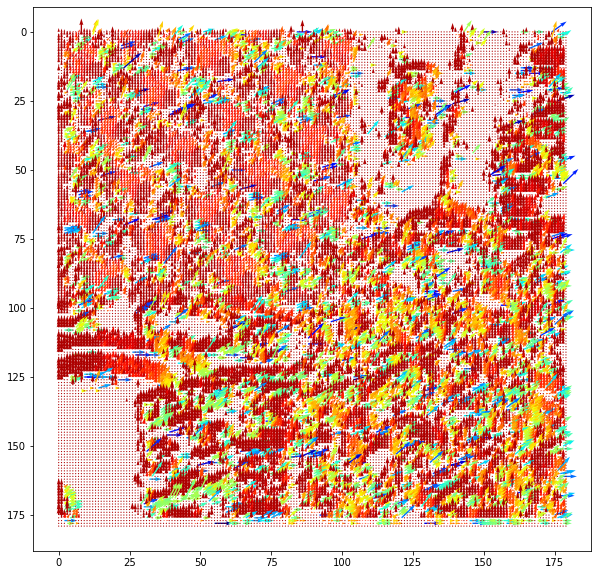

In [17]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, U, scale =3, cmap="jet_r")
plt.gca().invert_yaxis()

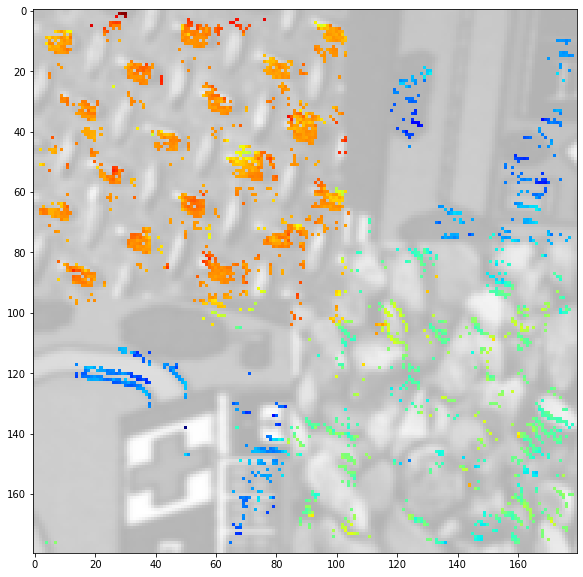

In [18]:
plt.figure(figsize=(10, 10))
img_gray = plt.imread(path + "data/sim/images/frame_00000022.png")
final_td = np.abs(np.ma.masked_where(final_td == 0, final_td))
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(final_td, cmap="jet_r", interpolation="none")
#plt.colorbar(m)

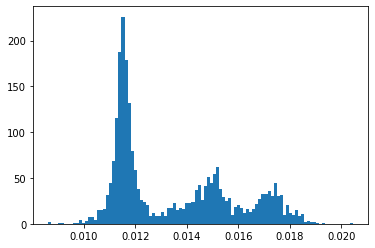

In [19]:
plt.hist(final_td.compressed(), 100);

In [12]:
u = np.divide(1.0, final_td, where=final_td!=0.0)

C:\Users\schiavaz\AppData\Local\Temp/ipykernel_28524/938763134.py:1: RuntimeWarning: divide by zero encountered in true_divide
  u = np.divide(1.0, final_td, where=final_td!=0.0)


In [13]:
id_speed = np.searchsorted(gt[:,0], start_time+duration/2)
v = np.sqrt(np.square(speed[0, id_speed]) + np.square(speed[1, id_speed]))

In [14]:
f = 171.377761856

In [15]:
d = td.v2depth(u, v, f)

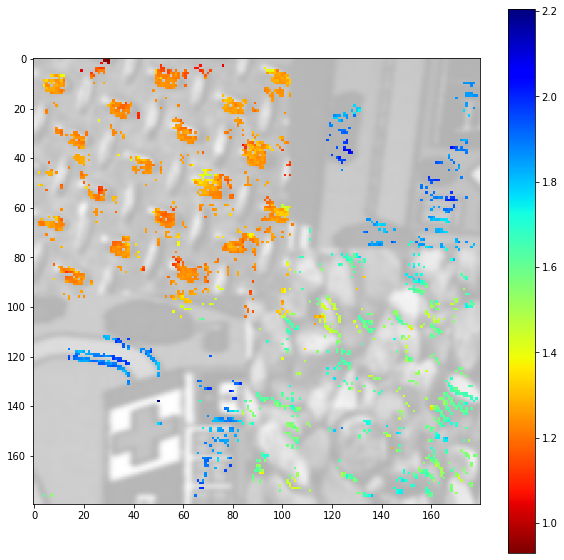

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(d, cmap="jet_r", interpolation="none")
plt.colorbar(m)

In [17]:
%matplotlib qt
vis.visualize3d(d)

In [18]:
points = vis._image2pointcloud(d)

calib = np.loadtxt(path + "/data/sim/calib.txt")
gt = np.loadtxt(path + "/data/sim/groundtruth.txt")
idx = np.searchsorted(gt[:, 0], start_time)
pose = gt[idx]

proj = td.project3d(points, calib, pose)

In [19]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s=2, c=proj[:, 2], cmap="jet_r")
#ax.set_zlim3d([0.5, 2.5])
vis._set_axes_equal(ax)
plt.show()

In [20]:
proj = proj[proj[:,2] < 3]
pcd = vis.points_to_open3d_pointcloud(proj[:,:3])

o3d.visualization.draw_geometries([pcd])

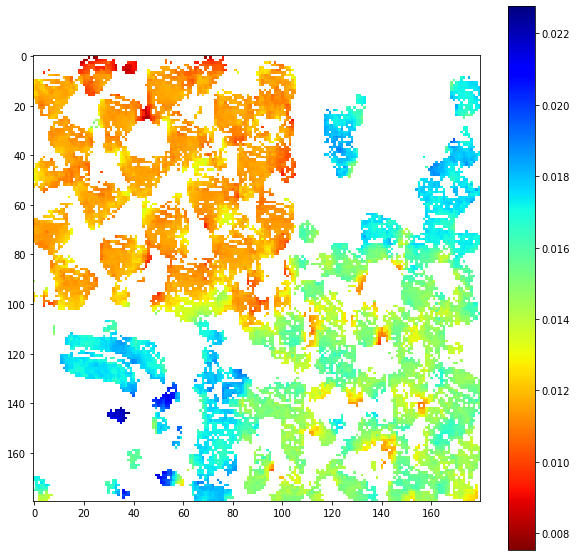

In [21]:
%matplotlib inline
img, count = td.mean_from_dict(td_predictions, shape, 10)
img_m = np.abs(np.ma.masked_where(img==0, img))
plt.figure(figsize=(10, 10))
m = plt.imshow(img_m, cmap="jet_r", interpolation="none")
plt.colorbar(m)

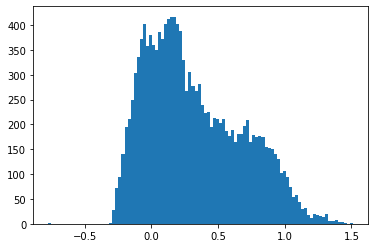

In [22]:
angles = np.array(angles)
plt.hist(angles, 100);

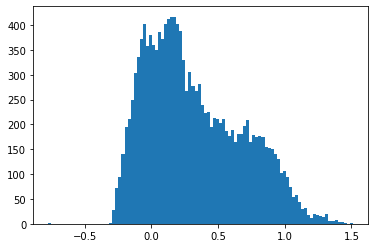

In [23]:
angles_u = np.unwrap(angles)
plt.hist(angles_u, 100);

In [24]:
x = 0
y = 0
a = np.pi / 6

u = 3
v = 1

x_p = x + np.cos(a)*u + np.sin(a)*v
y_p = y + np.sin(a)*u - np.cos(a)*v

In [25]:
print(x_p)
print(y_p)

3.098076211353316
0.6339745962155611


In [19]:
last_time = np.full(shape, -1.0)
dist = 2
td_predictions = {}
predictions = {}
px_range_pred = 7
event_sign = np.full(shape, -1)

angles = []

U = np.zeros(shape)
V = np.zeros(shape)
ofs = np.zeros(shape)

final_td = np.zeros(shape)

for e in tqdm(events):
    x = int(e[1])
    y = int(e[2])
    
#     if e[3] == 0:
#         continue
    
    last_sign = event_sign[y, x]
    last_time[y, x] = e[0]
    event_sign[y, x] = e[3]
    
    u_td = (e[0] - last_time[y-dist, x] 
            if y-dist >= 0 and last_time[y-dist, x] != -1.0 and event_sign[y-dist, x] == e[3]
            else float("Nan"))
    d_td = (e[0] - last_time[y+dist, x] 
            if y+dist<shape[0] and last_time[y+dist, x] != -1.0 and event_sign[y+dist, x] == e[3]
            else float("Nan"))
    r_td = (e[0] - last_time[y, x+dist] 
            if x+dist < shape[1] and last_time[y, x+dist] != -1.0 and event_sign[y, x+dist] == e[3]
            else float("Nan"))
    l_td = (e[0] - last_time[y, x-dist] 
            if x-dist >= 0 and last_time[y, x-dist] != -1.0 and event_sign[y, x-dist] == e[3]
            else float("Nan"))
    
    #get camera direction
    id_direction = np.searchsorted(gt[:,0], e[0])
    direction = directions[id_direction] - np.pi
    direction = np.mod(direction, 2*np.pi)
    
    #print(np.rad2deg(direction))
    
    if 0.0 <= direction < np.pi/2:
        v_td = d_td
        h_td = l_td
    elif np.pi/2 <= direction < np.pi:
        v_td = d_td
        h_td = -r_td
    elif np.pi <= direction < (3/2)*np.pi:
        v_td = -u_td
        h_td = -r_td
    elif (3/2)*np.pi <= direction < 2*np.pi:
        v_td = -u_td
        h_td = l_td
    
#     v_td = -u_td if not np.isnan(u_td) else d_td
#     h_td = -r_td if not np.isnan(r_td) else l_td

    U[y, x] = h_td if not np.isnan(h_td) else 0
    V[y, x] = v_td if not np.isnan(v_td) else 0
    
    if np.isnan(v_td) or np.isnan(h_td):
        continue
    
    
    m = np.sqrt(np.square(v_td) + np.square(h_td))
    a = direction - np.arctan2(v_td, h_td)
    
    angles.append(a)
    
    of = m * np.cos(a)
    ofs[y, x] = of
    time_difference = of / dist
    
    if (y, x) in td_predictions:
        mean_pred = np.mean(td_predictions[y, x])
        
        if 0.1 > np.abs(mean_pred - time_difference) > 0.003:
            last_time[y, x] = -1.0
            event_sign[y, x] = last_sign
            continue
        if np.abs(mean_pred - time_difference) > 0.1:
            td_predictions[y, x] = []
            predictions[y, x] = []
            continue
        if e[0] > start_time + duration -0.03 and len(td_predictions[y, x]) > 10:
            final_td[y, x] = mean_pred
            
    td_predictions[y, x] = []
    a = direction
    
    for i in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
        for k in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
            x_p = x + i
            y_p = y + k
            
            pred_time = last_time[y, x] + time_difference * i

            if x_p < 0 or x_p >= shape[1] or y_p < 0 or y_p >= shape[0]:
                continue
            
            if (y_p, x_p) in predictions:
                predictions[y_p, x_p].append(pred_time)
                td_predictions[y_p, x_p].append(time_difference)
            else:
                predictions[y_p, x_p] = [pred_time]
                td_predictions[y_p, x_p] = [time_difference]

100%|█████████████████████████████████████████████████████████████████████████| 45923/45923 [00:02<00:00, 18890.43it/s]


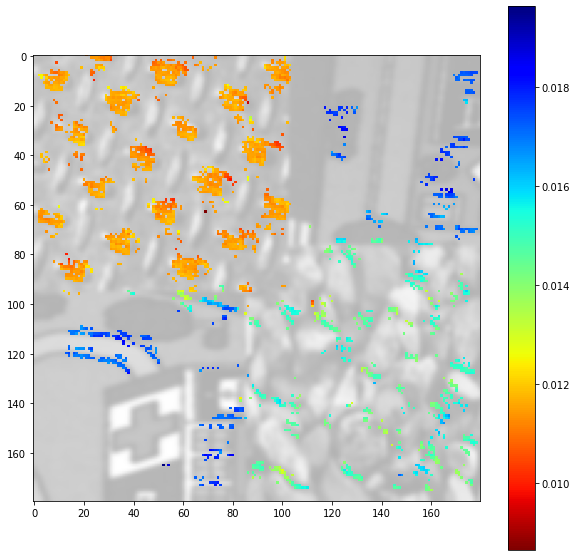

In [20]:
plt.figure(figsize=(10, 10))
img_gray = plt.imread(path + "data/sim/images/frame_00000022.png")
final_td = np.abs(np.ma.masked_where(final_td == 0, final_td))
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(final_td, cmap="jet_r", interpolation="none")
plt.colorbar(m)

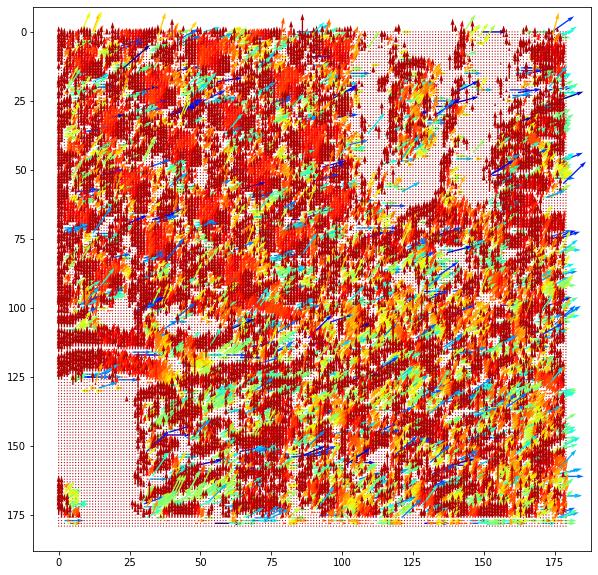

In [23]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, U, scale =2, cmap="jet_r")
plt.gca().invert_yaxis()

In [57]:
u = np.divide(1.0, final_td, where=final_td!=0.0)

id_speed = np.searchsorted(gt[:,0], start_time+duration/2)
v = np.sqrt(np.square(speed[0, id_speed]) + np.square(speed[1, id_speed]))

f = 171.377761856

C:\Users\schiavaz\AppData\Local\Temp/ipykernel_28524/2171134278.py:1: RuntimeWarning: divide by zero encountered in true_divide
  u = np.divide(1.0, final_td, where=final_td!=0.0)


In [58]:
d = td.v2depth(u, v, f)

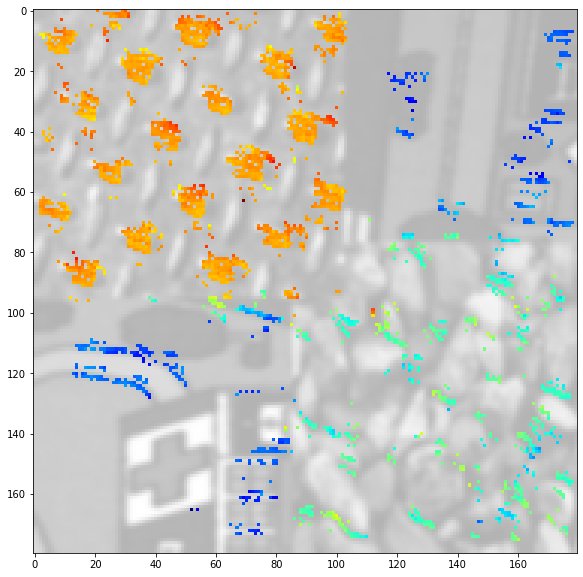

In [59]:
plt.figure(figsize=(10, 10))
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(d, cmap="jet_r", interpolation="none")
#plt.colorbar(m)

In [60]:
%matplotlib qt
vis.visualize3d(d)

In [68]:
points = vis._image2pointcloud(d)

calib = np.loadtxt(path + "/data/sim/calib.txt")
gt = np.loadtxt(path + "/data/sim/groundtruth.txt")
idx = np.searchsorted(gt[:, 0], start_time)
pose = gt[idx]

proj = td.project3d(points, calib, pose)

In [70]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s=2, c=proj[:, 2], cmap="jet")
vis._set_axes_equal(ax)
plt.show()

In [63]:
calib = np.loadtxt(path + "/data/slider-depth/calib.txt")
gt = np.loadtxt(path + "/data/slider-depth/groundtruth.txt")
idx = np.searchsorted(gt[:, 0], start_time)
pose = gt[idx]

In [64]:
proj = td.project3d(points, calib, pose)

In [65]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s=2, c=proj[:, 2], cmap="jet_r", vmin=0.5, vmax=2.5)
ax.set_zlim3d([0.5, 2.5])
vis._set_axes_equal(ax)
plt.show()

In [66]:
proj = proj[proj[:,2] < 3]
pcd = vis.points_to_open3d_pointcloud(proj[:,:3])

In [67]:
o3d.visualization.draw_geometries([pcd])

In [39]:
last_time = np.full(shape, -1.0)
dist = 2
td_predictions = {}
predictions = {}
px_range_pred = 7
event_sign = np.full(shape, -1)

angles = []

U = np.zeros(shape)
V = np.zeros(shape)
ofs = np.zeros(shape)

final_td = np.zeros(shape)

for e in tqdm(events):
    x = int(e[1])
    y = int(e[2])
    
#     if e[3] == 0:
#         continue
    
    last_sign = event_sign[y, x]
    last_time[y, x] = e[0]
    event_sign[y, x] = e[3]
    
    u_td = (e[0] - last_time[y-dist, x] 
            if y-dist >= 0 and last_time[y-dist, x] != -1.0 and event_sign[y-dist, x] == e[3]
            else float("Nan"))
    d_td = (e[0] - last_time[y+dist, x] 
            if y+dist<shape[0] and last_time[y+dist, x] != -1.0 and event_sign[y+dist, x] == e[3]
            else float("Nan"))
    r_td = (e[0] - last_time[y, x+dist] 
            if x+dist < shape[1] and last_time[y, x+dist] != -1.0 and event_sign[y, x+dist] == e[3]
            else float("Nan"))
    l_td = (e[0] - last_time[y, x-dist] 
            if x-dist >= 0 and last_time[y, x-dist] != -1.0 and event_sign[y, x-dist] == e[3]
            else float("Nan"))
    
    #get camera direction
    id_direction = np.searchsorted(gt[:,0], e[0])
    direction = directions[id_direction] - np.pi
    direction = np.mod(direction, 2*np.pi)
    
#     print(np.rad2deg(direction))
    
    if 0.0 <= direction < np.pi/2:
        v_td = d_td
        h_td = l_td
    elif np.pi/2 <= direction < np.pi:
        v_td = d_td
        h_td = -r_td
    elif np.pi <= direction < (3/2)*np.pi:
        v_td = -u_td
        h_td = -r_td
    elif (3/2)*np.pi <= direction < 2*np.pi:
        v_td = -u_td
        h_td = l_td
    
#     v_td = -u_td if not np.isnan(u_td) else d_td
#     h_td = -r_td if not np.isnan(r_td) else l_td

    U[y, x] = h_td if not np.isnan(h_td) else 0
    V[y, x] = v_td if not np.isnan(v_td) else 0
    
    if np.isnan(v_td) or np.isnan(h_td):
        continue
    
    
    m = np.sqrt(np.square(v_td) + np.square(h_td))
    a = direction - np.arctan2(v_td, h_td)
    
    angles.append(a)
    
    of = m * np.cos(a)
    ofs[y, x] = of
    time_difference = of / dist
    
    if (y, x) in td_predictions:
        mean_pred = np.mean(td_predictions[y, x])
        arr_pred = np.mean(predictions[y, x])
        
        if np.abs(e[0] - arr_pred) > 0.03:
            last_time[y, x] = -1.0
            event_sign[y, x] = last_sign
            continue
        
#         if 0.1 > np.abs(mean_pred - time_difference) > 0.003:
#             last_time[y, x] = -1.0
#             event_sign[y, x] = last_sign
#             continue
        if np.abs(mean_pred - time_difference) > 0.1:
            td_predictions[y, x] = []
            predictions[y, x] = []
            continue
        if e[0] > start_time + duration -0.03 and len(td_predictions[y, x]) > 10:
            final_td[y, x] = mean_pred
            
    td_predictions[y, x] = []
    a = direction
    
    for i in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
        for k in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
            x_p = x + i
            y_p = y + k
            
            pred_time = last_time[y, x] + time_difference * i

            if x_p < 0 or x_p >= shape[1] or y_p < 0 or y_p >= shape[0]:
                continue
            
            if (y_p, x_p) in predictions:
                predictions[y_p, x_p].append(pred_time)
                td_predictions[y_p, x_p].append(time_difference)
            else:
                predictions[y_p, x_p] = [pred_time]
                td_predictions[y_p, x_p] = [time_difference]

100%|█████████████████████████████████████████████████████████████████████████| 45923/45923 [00:02<00:00, 21812.94it/s]


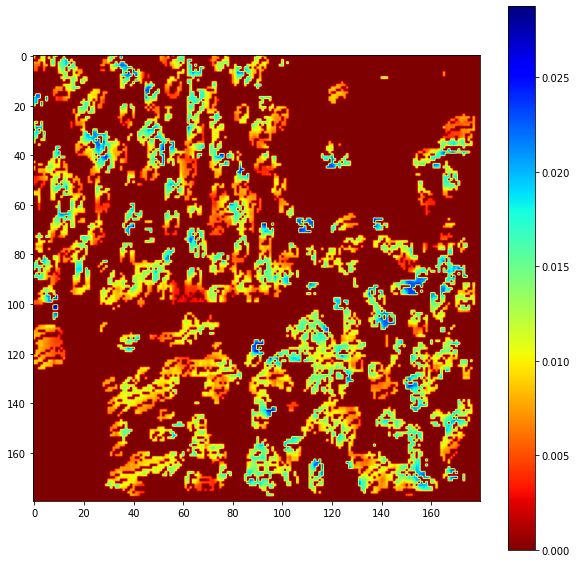

In [40]:
%matplotlib inline
img, count = td.mean_from_dict(td_predictions, shape, 10)

plt.figure(figsize=(10, 10))
m = plt.imshow(img, cmap="jet_r")
plt.colorbar(m)

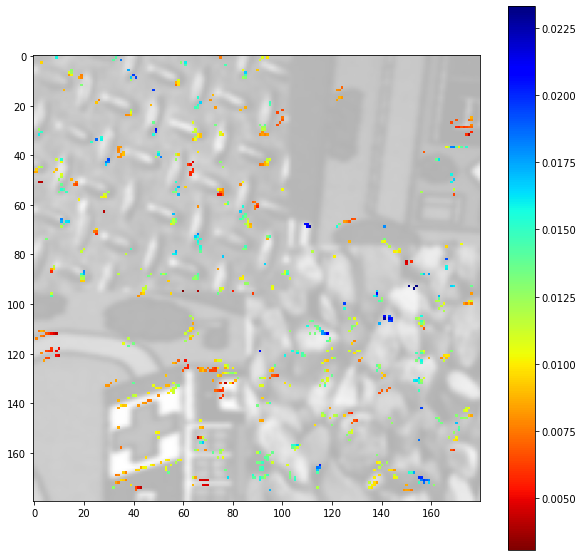

In [41]:
plt.figure(figsize=(10, 10))
img_gray = plt.imread(path + "data/sim/images/frame_00000022.png")
final_td = np.abs(np.ma.masked_where(final_td == 0, final_td))
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(final_td, cmap="jet_r", interpolation="none")
plt.colorbar(m)

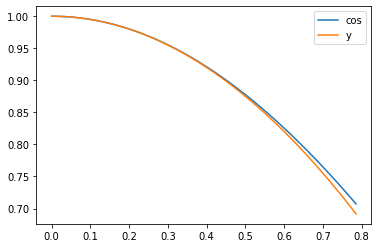

In [42]:
x = np.linspace(0, np.pi/4, 100)
c = np.cos(x)
y = 1 - x**2 / 2

plt.plot(x, c, label="cos")
plt.plot(x, y, label="y")
plt.legend()